![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/TrainingNotebooks/tutorials/Certification_Trainings/1.3.Trasformer_based_Text_Recognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

**Please choose GPU runtime**

In [ ]:
## Setup

In [2]:
import os
import pkg_resources
from pyspark.ml import PipelineModel
import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

spark = start_spark()
print("Spark OCR Version :", sparkocr.version())

## Read image


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


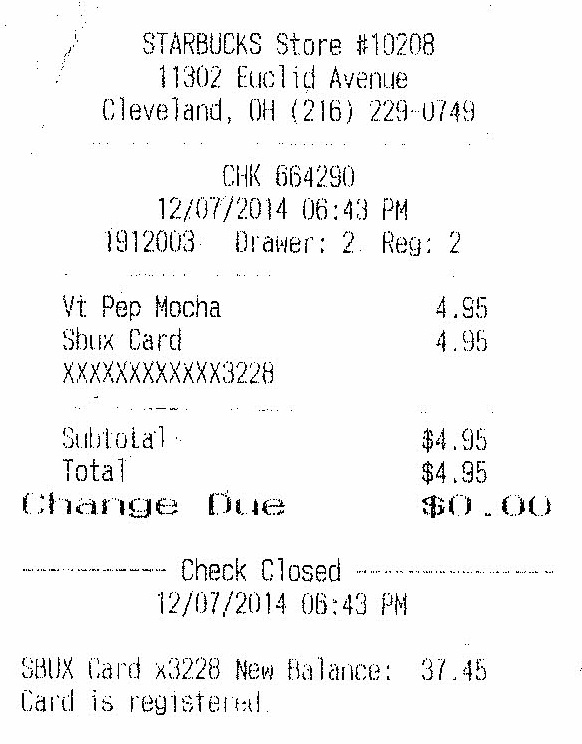

In [4]:
image_path = visual.pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_example_df = spark.read.format("binaryFile").load(image_path)
image_df = visual.BinaryToImage().transform(image_example_df).cache()

visual.display_images(image_df)

In [5]:
binary_to_image = visual.BinaryToImage() 
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

text_detector = visual.ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10) \
    .setWithRefiner(True)

draw_regions = visual.ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(visual.Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


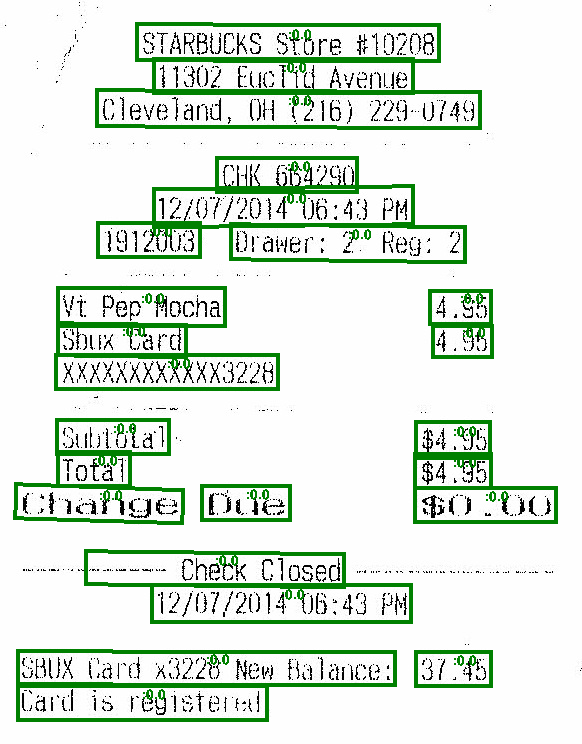

In [6]:
result = pipeline.transform(image_example_df)
visual.display_images(result, "image_with_regions")

## Disable refiner and tune thresholds for detect each word separately


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


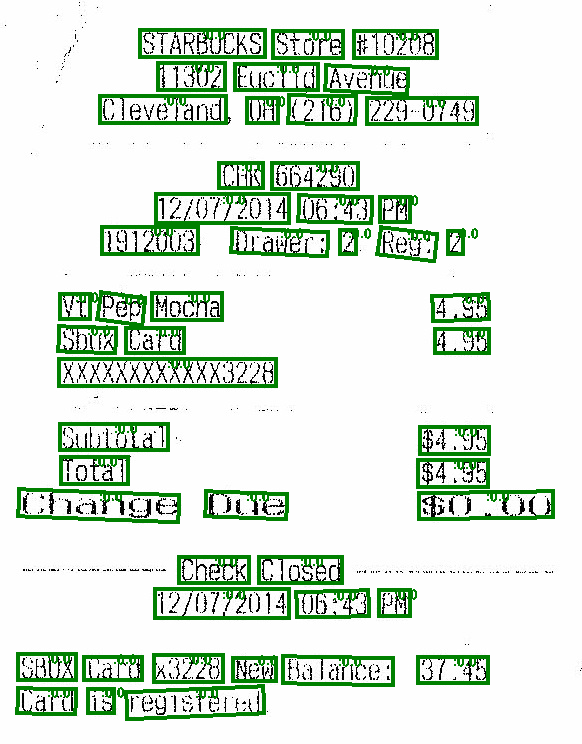

In [7]:
pipeline.stages[1].setWithRefiner(False)
pipeline.stages[1].setSizeThreshold(15)
pipeline.stages[1].setLinkThreshold(0.3)
pipeline.stages[1].setScoreThreshold(0.7)
pipeline.stages[1].setTextThreshold(0.4)
pipeline.stages[1].setMergeIntersects(True)

result = pipeline.transform(image_example_df)
visual.display_images(result, "image_with_regions")

In [8]:
ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions")\
    .setInputCols(["image"]) \
    .setOutputCol("text") \
    .setOutputFormat(visual.OcrOutputFormat.TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False)

print(("").join([x.text for x in ocr.transform(result).select("text").collect()]))

ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB
STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003 DRAMER: 2 REG: 2
VT PEP MOCHA 4.95
SBUX CARD 4.95
XXXXXXXXXXXX3228
SUBTOTAL $4.95
TOTAL $4.95
CHANGE DUE $0.00
CHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


In [9]:
ocr_formatted = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions")\
    .setInputCols(["image"]) \
    .setOutputCol("text_formatted") \
    .setOutputFormat(visual.OcrOutputFormat.FORMATTED_TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(True)

print(("").join([x.text_formatted for x in ocr_formatted.transform(result).select("text_formatted").collect()]))

ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB
          STARBUCKS  STORE #10208
            11302 EUCLID AVENUE
       CLEVELAND  OH  (216) 229-0749

                CHK 664290
           12/07/2014 06:43  PM
       1912003   DRAMER:  2  REG: 2

    VT PEP MOCHA                 4.95
    SBUX CARD                    4.95
    XXXXXXXXXXXX3228

    SUBTOTAL                    $4.95
    TOTAL                       $4.95
 CHANGE        DUE              $0.00

             CHECK CLOSED
           12/07/2014 06:43  PM

 SBUX CARD X3228 NEW BALANCE:   37.45
 CARD IS REGISTERED
